# OilyGiant Mining - Oil Well Development Modeling

## 1. Introduction
- The objective of this project is to develop a model that will predict the optimal region for oil well development by maximizing the profit margin, within the bounds of acceptable risk of loss.
- There are three datasets representing various regions with undefined features influencing the viability of developments of these wells, as well as information on the volume of oil reserves present in each prospective well.

## 2. Approach
The data from all three regions shall be preprocessed to ensure it is suitable for model training that the following issues are dealt with:
- Missing Data
- Duplicated Rows
- Improperly Formatted Column Names
- Incorrect Data Types
- Feature Engineering
    - The unit revenue rate per barrel is known (\$4500 USD per 1000 barrels), therefore a `revenue` column shall be created for each dataset based on the `product` column representing oil reserves available in each well in 1000s of barrels.
    -  An `op_ex` column shall be created by dividing 100,000,000 by 200 to represent the cost of development per well and serve as a helper column in calculating the `net_profit` column.
    -  The `net_profit` column shall be created by calculating the difference of the `revenue` and `op_ex` columns (please note that this analysis assumes well development is an operating expense and not a COGS, and that COGS = \$0).
    -  An `roi` column shall created by dividing `net_profit` by `op_ex` for each well.  

The `fx` columns shall then be plotted against the `product`, `net_profit`, and `roi` columns for each region's dataset and commented on to observe whether there are any interesting observations to assist in focusing the analysis in the correct region.

The source data shall then be split into a:
- Training Set (80%), and
- Test Set (20%)

The Training Set shall then be cross-validated using the a custom cross-validation function defined in the __Initialization__ section.
This will enforce five folds of cross-validation respecting the 75% training and 25% split required by OilyGiant.
- Bootstrapping shall be applied to the training set to estimate the variability in predicted `net_profit` for each well by sampling the training data with replacement for 1000 iterations, retrain the model on each sample, and compute the predicted profit for each well.
    - The percentage of iterations in which the predicted profit falls below zero will be captured in the `risk_of_loss%` for each well.

The model used for this analysis shall be __Linear Regression__:
- Ultimately, the `fx` features shall be used to predict the `net_profit` of each well and aid in identifying the most lucrative region for well development.
- The region with the greatest number of high-ROI, low-risk wells based on bootstrapped estimates shall be recommended as target region for well development.
- The top 200 wells shall be selected based on the highest expected net profit from a study of 500 wells in the target region.

## 3. Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML

state = np.random.RandomState(seed=777) # Establish pseudorandom conditions up-front
budget = 100_000_000 # Corrected for the profit function modularity

# Custom Cross-Validation Function (75% Training / 25% Validation)
def repeated_random_cv_full(feat_train, target_train, n_repeats=5, val_size=0.25, rng=state):
    all_preds = []
    all_actuals = []
    all_split_ids = []
    rmse_list = []

    for i in range(n_repeats): # Iterates over 5x 75/25 folds with a different seed spawned from RandomState 777
        seed_i = rng.randint(0, 10**6)
        feat_subtrain, feat_val, target_subtrain, target_val = train_test_split(
            feat_train, target_train, test_size=val_size, random_state=seed_i
        )
        model = LinearRegression() 
        model.fit(feat_subtrain, target_subtrain) # Train the model using the 75% training set from the outer split
        preds = model.predict(feat_val)

        all_preds.extend(preds) # Capture all iteration predictions
        all_actuals.extend(target_val) # Capture all validation actuals
        all_split_ids.extend([i + 1] * len(target_val)) # Document the iteration ID

        mse = mean_squared_error(target_val, preds)
        rmse = np.sqrt(mse)
        rmse_list.append(rmse) 

    preds_df = pd.DataFrame({ # Summarize in a neat table
        'split_id': all_split_ids,
        'predicted_volume': all_preds, # Changed from net_profit to volume
        'actual_volume': all_actuals # Changed from net_profit to volume
    })

    avg_rmse = np.mean(rmse_list)
    avg_predicted_volume = np.mean(all_preds)

    print(f"Avg RMSE across {n_repeats} folds: {avg_rmse:.2f}")
    print(f"Avg Predicted Volume: {avg_predicted_volume:.2f}") # Changed from Predicted Net Profit to Predicted Volume

    return avg_rmse, avg_predicted_volume, preds_df # Changed from avg_predicted_profit to avg_predicted_volume

# Profit Calculation Function - Per Feedback below to integrate into Boostrapping Function
def calculate_profit(volume_series):
    revenue = volume_series * 4500
    return revenue - budget # Removed `op_ex` and replaced with modular `budget` variable

# Bootstrapping Function (500-Well Analysis)
def bootstrap_profit_analysis(feat_test, target_test, feat_train, target_train, n_iterations=1000, rng=state):
    profits = [] # Prep list to store total profit for each iteration

    feat_test = feat_test.reset_index(drop=True) # Dropping indexing of test sets for clean indexing in next step
    target_test = target_test.reset_index(drop=True)

    for _ in range(n_iterations): # Repeat this behavior for 1000 iterations
        sample_idx = rng.choice(feat_test.index, size=500, replace=True) # Randomly choose 500 wells with replacement
        feat_sample = feat_test.loc[sample_idx] # Synthesize a training set based on those 500 wells
        target_sample = target_test.loc[sample_idx]

        model = LinearRegression()
        model.fit(feat_train, target_train) # Use total training set to ensure sufficient training

        predicted_profits = model.predict(feat_sample) # See how well the model predicts the sample 500
        top_200_idx = np.argsort(predicted_profits)[-200:] # Sort the 500 predictions and get top 200 indices
        actual_volume = target_sample.iloc[top_200_idx].sum() # Calculate top 200 profit **CORRECTED TO SUPPORT NEW calculate_profit() FUNCTION DEFINED ABOVE PER FEEDBACK
        actual_profit = calculate_profit(actual_volume).sum()

        profits.append(actual_profit)

    profit_distribution = np.array(profits) 

    summary = {
        'average_profit': profit_distribution.mean(),
        '95%_ci_lower': np.percentile(profit_distribution, 2.5),
        '95%_ci_upper': np.percentile(profit_distribution, 97.5),
        'risk_of_loss_%': (profit_distribution < 0).mean() * 100 # Percent of simulations where total profit was negative
    }

    return profit_distribution, summary

The Bootstrapping Function performs the following steps:
- Randomly chooses 500 wells without replacement
- Creates a temporary training set based on those 500 wells,
- Trains a Linear Regression model using the entire training set,
- Predicts the profits using the feature of the temporary training set as an input,
- Sorts the 500 predictions and calculates the top 200 profits,
- Iterates this 1000 times and creates an array, and
- Summarizes the data on the following outputs:
  - Average Profit
  - Lower Quartile
  - Upper Quartile
  - Risk of Loss % (Percent of 1000 boostrap simulations where the total profit was negative)

## 4. Data Preparation

#### 4.1 Region 0 Dataset

In [2]:
# Data verification and preprocessing for Region 0

r0_df = pd.read_csv('../data/geo_data_0.csv')
display(r0_df.info())
print('There are', r0_df.duplicated().sum(), 'duplicated rows.')
print()
print('Missing values per column:\n', r0_df.isna().sum())
print()

# Feature Engineering
r0_df['revenue'] = r0_df['product'] * 4500 
r0_df['op_ex'] = 100_000_000 / 200
r0_df['net_profit'] = r0_df['revenue'] - r0_df['op_ex']
r0_df['roi'] = r0_df['net_profit'] / r0_df['op_ex']

# Data Preview
display(r0_df.head())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

There are 0 duplicated rows.

Missing values per column:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



id        f0        f1        f2     product        revenue     op_ex  \
0  txEyH  0.705745 -0.497823  1.221170  105.280062  473760.278296  500000.0   
1  2acmU  1.334711 -0.340164  4.365080   73.037750  328669.876193  500000.0   
2  409Wp  1.022732  0.151990  1.419926   85.265647  383695.412089  500000.0   
3  iJLyR -0.032172  0.139033  2.978566  168.620776  758793.489998  500000.0   
4  Xdl7t  1.988431  0.155413  4.751769  154.036647  693164.910318  500000.0   

      net_profit       roi  
0  -26239.721704 -0.052479  
1 -171330.123807 -0.342660  
2 -116304.587911 -0.232609  
3  258793.489998  0.517587  
4  193164.910318  0.386330

                  f2   product   revenue  net_profit       roi
f2          1.000000  0.483663  0.483663    0.483663  0.483663
product     0.483663  1.000000  1.000000    1.000000  1.000000
revenue     0.483663  1.000000  1.000000    1.000000  1.000000
net_profit  0.483663  1.000000  1.000000    1.000000  1.000000
roi         0.483663  1.000000  1.000000    1.000000  1.000000

63417 wells have negative net profit out of 100000


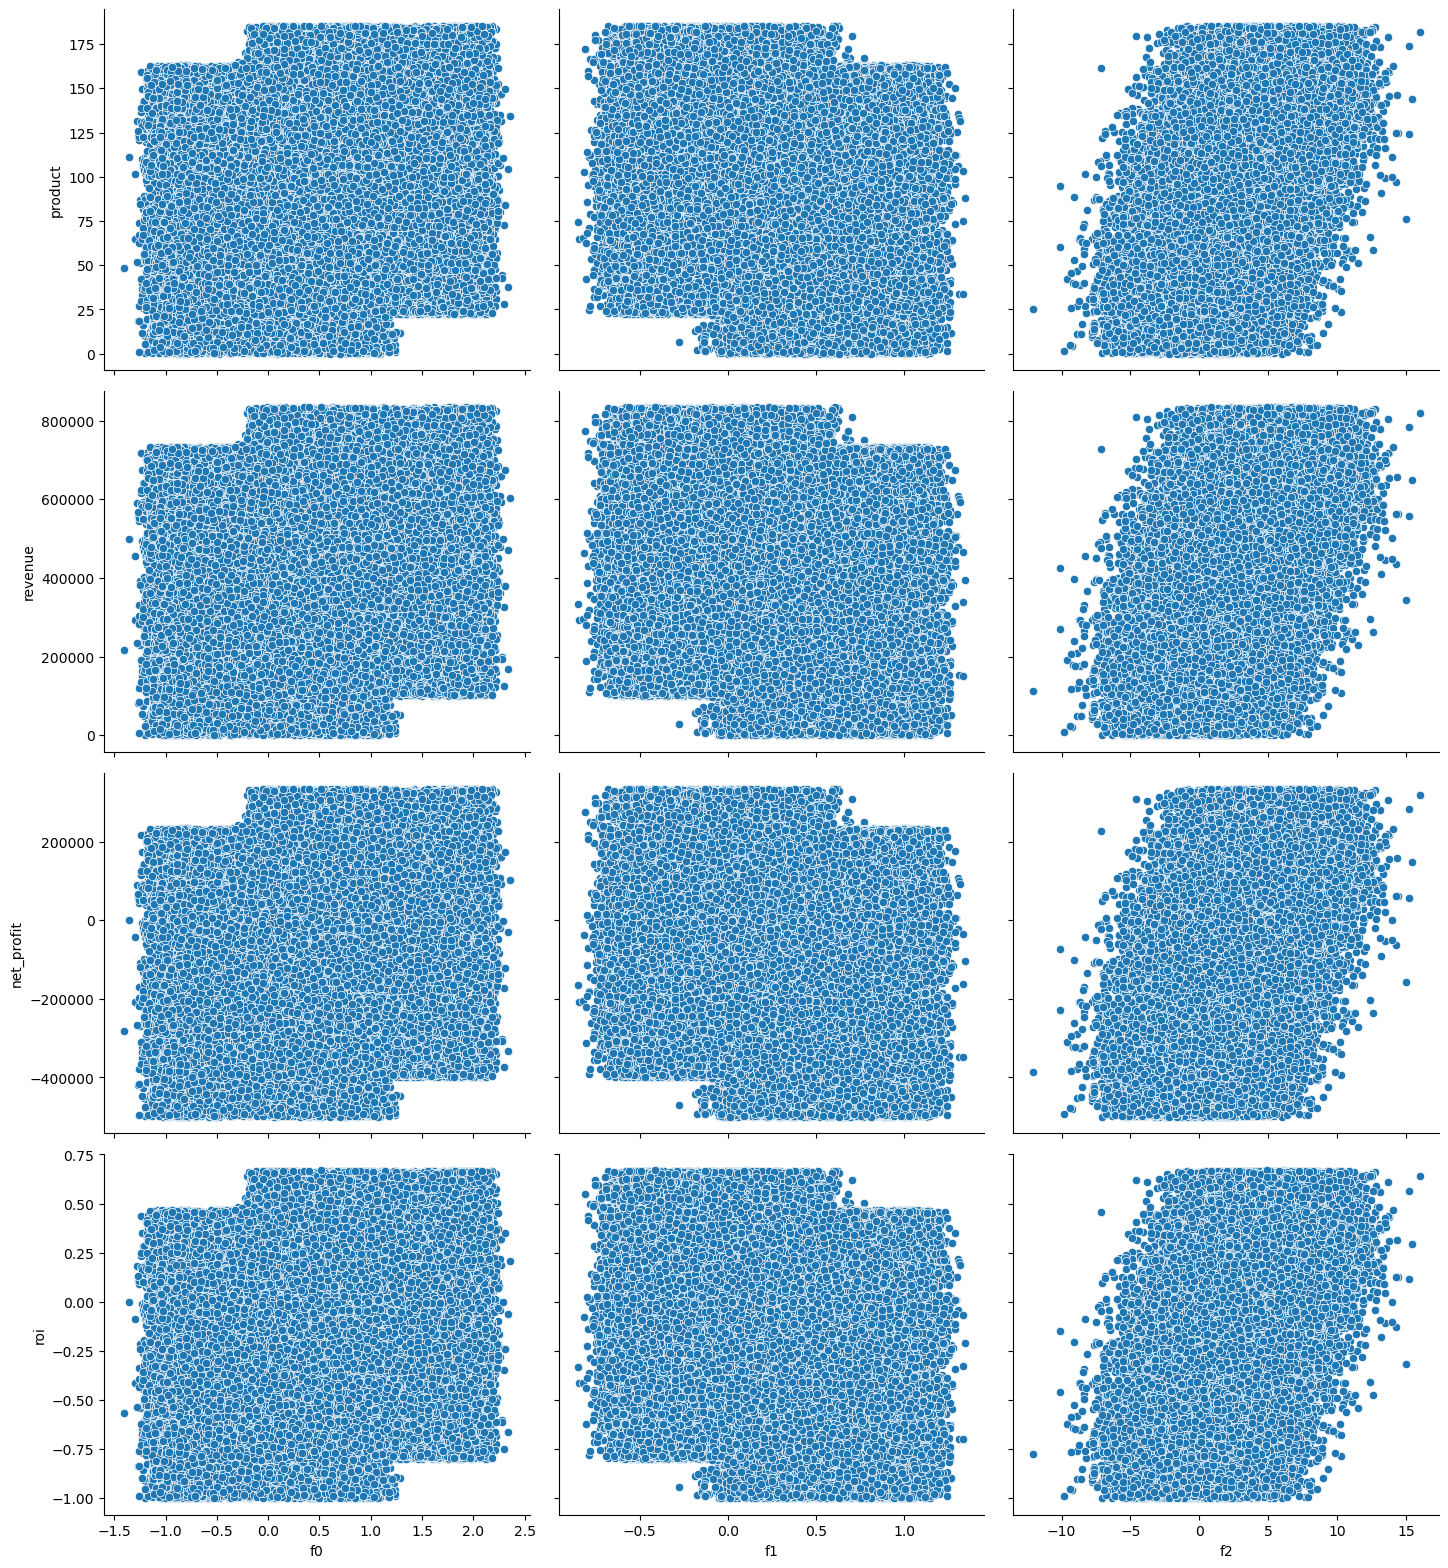

In [3]:
# Review relationships of fx columns against product, revenue, net_profit, and roi

r0_pair = sns.PairGrid(r0_df, x_vars=['f0', 'f1', 'f2'], 
                    y_vars=['product', 'revenue', 'net_profit', 'roi'],
                    height=4, aspect=1.2)
r0_pair.map(sns.scatterplot)

print(r0_df[['f2', 'product', 'revenue', 'net_profit', 'roi']].corr())
print()
print((r0_df['net_profit'] < 0).sum(), 'wells have negative net profit out of', len(r0_df))

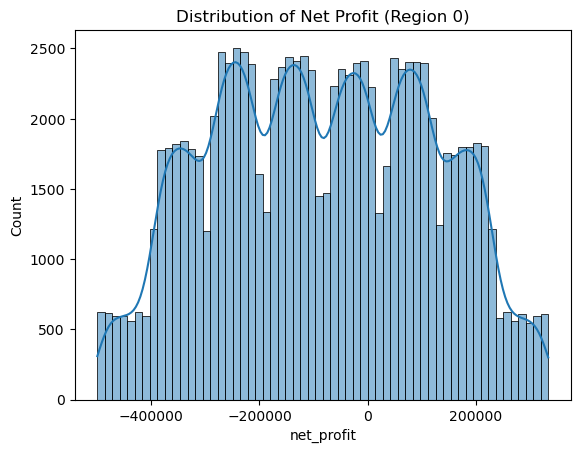

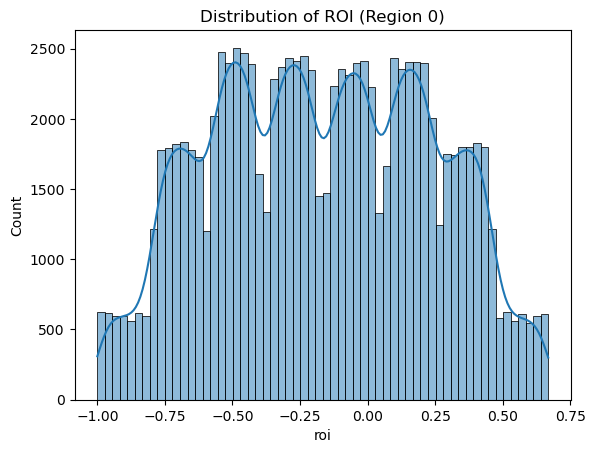

In [4]:
sns.histplot(r0_df['net_profit'], kde=True)
plt.title('Distribution of Net Profit (Region 0)')
plt.show()

sns.histplot(r0_df['roi'], kde=True)
plt.title('Distribution of ROI (Region 0)')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- No missing data, duplicated rows, and all incumbent datatypes are correct.
- `revenue`, `op_ex`, `net_profit`, and `roi` columns created without issue.
- Among the feature columns `f0`, `f1`, and `f2`, only the `f2` column appeared to have any semblance of a linear relationship with the derived columns `product`, `revenue`, `net_profit`, and `roi`.
    - The `f0` and `f1` visualizations against those same columns simply appeared as masses of noisy clouds with no apparent relationship, and therefore shall excluded as features in training the forthcoming model.
    - The correlation for `f2` was calculated against all of the derived columns and a weak positive correlation was detected (~0.484), supporting this conclusion.
    - There was a large number of wells in Region 0 that have a negative net profit (63,417 / 100,000 = ~63.4%), which may be concerning in the later part of the analysis.
- The distributions of `net_profit` and `roi` were also visualized.
    - The visualizations showed that neither data slice is normally distributed, supporting the necessity of bootstrapping later on in the process.

#### 4.2 Region 1 Dataset

In [5]:
# Data verification and preprocessing for Region 1

r1_df = pd.read_csv('../data/geo_data_1.csv')
display(r1_df.info())
print('There are', r1_df.duplicated().sum(), 'duplicated rows.')
print()
print('Missing values per column:\n', r1_df.isna().sum())
print()

# Feature Engineering
r1_df['revenue'] = r1_df['product'] * 4500 
r1_df['op_ex'] = 100_000_000 / 200
r1_df['net_profit'] = r1_df['revenue'] - r1_df['op_ex']
r1_df['roi'] = r1_df['net_profit'] / r1_df['op_ex']

# Data Preview
display(r1_df.head())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

There are 0 duplicated rows.

Missing values per column:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



id         f0         f1        f2     product        revenue     op_ex  \
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103   14305.961624  500000.0   
1  62mP7  14.272088  -3.475083  0.999183   26.953261  121289.674642  500000.0   
2  vyE1P   6.263187  -5.948386  5.001160  134.766305  606448.373210  500000.0   
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408  620754.334834  500000.0   
4  AHL4O  12.702195  -8.147433  5.004363  134.766305  606448.373210  500000.0   

      net_profit       roi  
0 -485694.038376 -0.971388  
1 -378710.325358 -0.757421  
2  106448.373210  0.212897  
3  120754.334834  0.241509  
4  106448.373210  0.212897

                  f2   product   revenue  net_profit       roi
f2          1.000000  0.999397  0.999397    0.999397  0.999397
product     0.999397  1.000000  1.000000    1.000000  1.000000
revenue     0.999397  1.000000  1.000000    1.000000  1.000000
net_profit  0.999397  1.000000  1.000000    1.000000  1.000000
roi         0.999397  1.000000  1.000000    1.000000  1.000000

83463 wells have negative net profit out of 100000


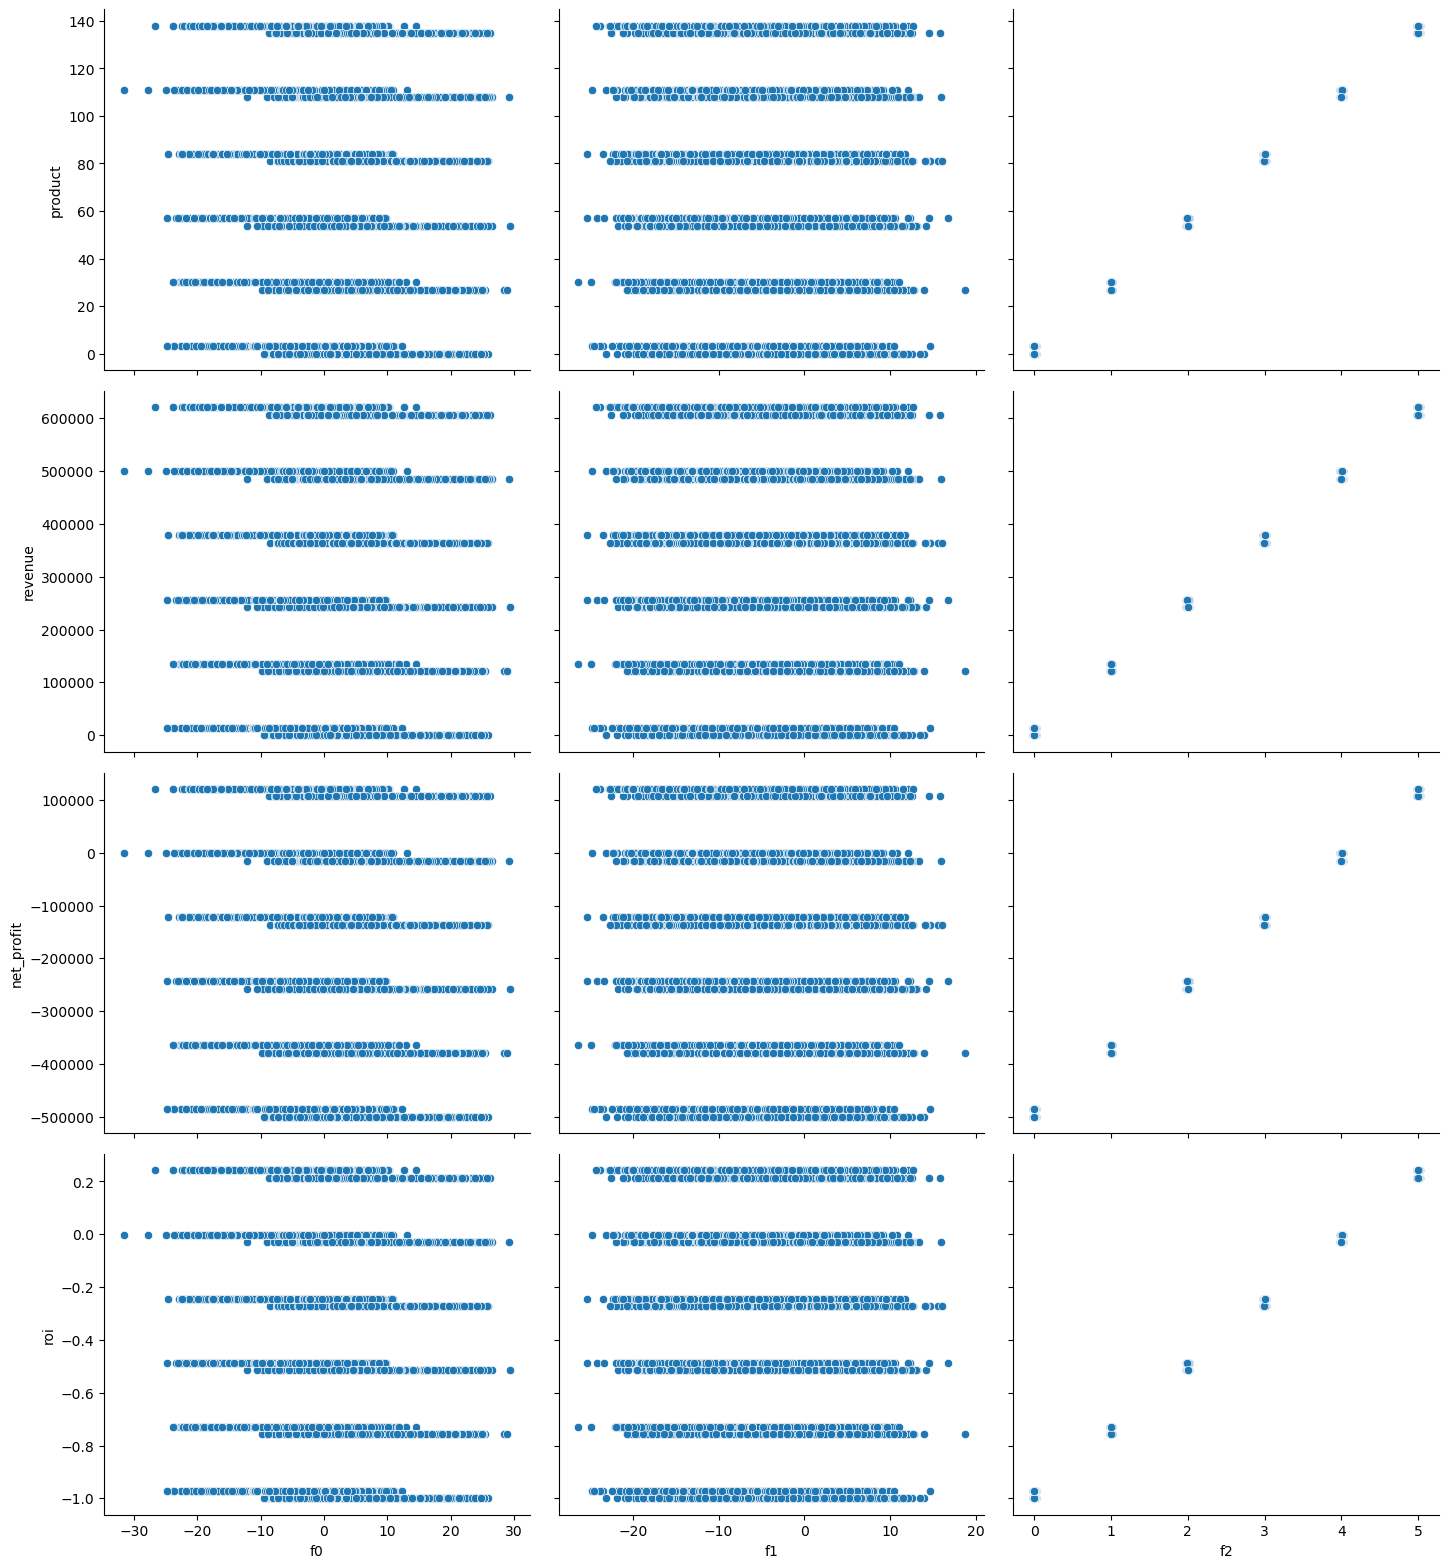

In [6]:
# Review relationships of fx columns against product, revenue, net_profit, and roi

r1_pair = sns.PairGrid(r1_df, x_vars=['f0', 'f1', 'f2'], 
                    y_vars=['product', 'revenue', 'net_profit', 'roi'],
                    height=4, aspect=1.2)
r1_pair.map(sns.scatterplot)

print(r1_df[['f2', 'product', 'revenue', 'net_profit', 'roi']].corr())
print()
print((r1_df['net_profit'] < 0).sum(), 'wells have negative net profit out of', len(r1_df))

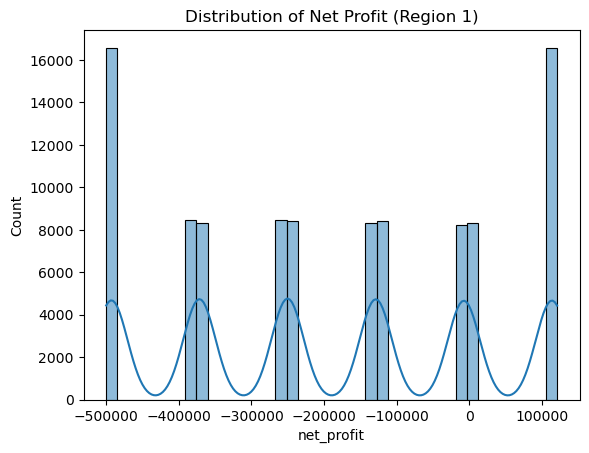

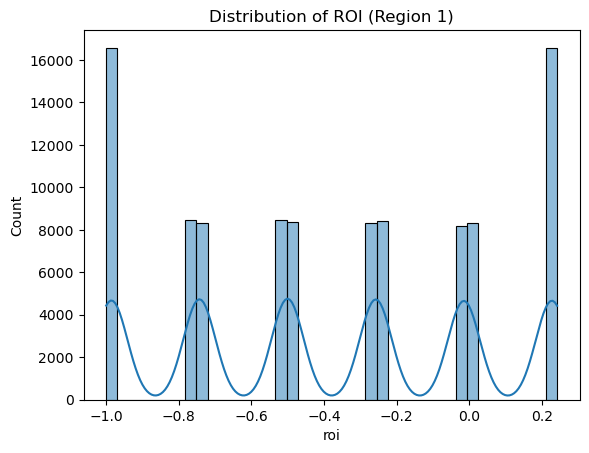

In [7]:
sns.histplot(r1_df['net_profit'], kde=True)
plt.title('Distribution of Net Profit (Region 1)')
plt.show()

sns.histplot(r1_df['roi'], kde=True)
plt.title('Distribution of ROI (Region 1)')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- No missing data, duplicated rows, and all incumbent datatypes are correct.
- `revenue`, `op_ex`, `net_profit`, and `roi` columns created without issue.
- Among the feature columns `f0`, `f1`, and `f2`, only the `f2` column appeared to have any semblance of a linear relationship with the derived columns `product`, `revenue`, `net_profit`, and `roi`.
    - The `f0` and `f1` visualizations against those same columns simply appeared as clusters of horizontal arranged clouds at all levels of the y-axis with no apparent relationship, and therefore shall excluded as features in training the forthcoming model.
    - The correlation for `f2` was calculated against all of the derived columns and a **strong** positive correlation was detected (~0.999), supporting this conclusion.
    - There was an even larger number of wells in Region 1 that have a negative net profit (83,463 / 100,000 = ~83.5%), which may be concerning in the later part of the analysis.
- The distributions of `net_profit` and `roi` were also visualized.
    - The visualizations showed that neither data slice is normally distributed, supporting the necessity of bootstrapping later on in the process.
    - It also appears that the magnitude of `net_profit` in **Region 1** is less than **Region 0** (based on the right-hand side of the x-axis in the `net_profit` distribution visuals). 

#### 4.3 Region 2 Dataset

In [8]:
# Data verification and preprocessing for Region 2

r2_df = pd.read_csv('../data/geo_data_2.csv')
display(r2_df.info())
print('There are', r2_df.duplicated().sum(), 'duplicated rows.')
print()
print('Missing values per column:\n', r2_df.isna().sum())
print()

# Feature Engineering
r2_df['revenue'] = r2_df['product'] * 4500 
r2_df['op_ex'] = 100_000_000 / 200
r2_df['net_profit'] = r2_df['revenue'] - r2_df['op_ex']
r2_df['roi'] = r2_df['net_profit'] / r2_df['op_ex']

# Data Preview
display(r2_df.head())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

There are 0 duplicated rows.

Missing values per column:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



id        f0        f1        f2     product        revenue     op_ex  \
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673  124914.029538  500000.0   
1  WJtFt  0.262778  0.269839 -2.530187   56.069697  252313.634846  500000.0   
2  ovLUW  0.194587  0.289035 -5.586433   62.871910  282923.595214  500000.0   
3  q6cA6  2.236060 -0.553760  0.930038  114.572842  515577.787504  500000.0   
4  WPMUX -0.515993  1.716266  5.899011  149.600746  673203.356607  500000.0   

      net_profit       roi  
0 -375085.970462 -0.750172  
1 -247686.365154 -0.495373  
2 -217076.404786 -0.434153  
3   15577.787504  0.031156  
4  173203.356607  0.346407

                  f2   product   revenue  net_profit       roi
f2          1.000000  0.445871  0.445871    0.445871  0.445871
product     0.445871  1.000000  1.000000    1.000000  1.000000
revenue     0.445871  1.000000  1.000000    1.000000  1.000000
net_profit  0.445871  1.000000  1.000000    1.000000  1.000000
roi         0.445871  1.000000  1.000000    1.000000  1.000000

61822 wells have negative net profit out of 100000


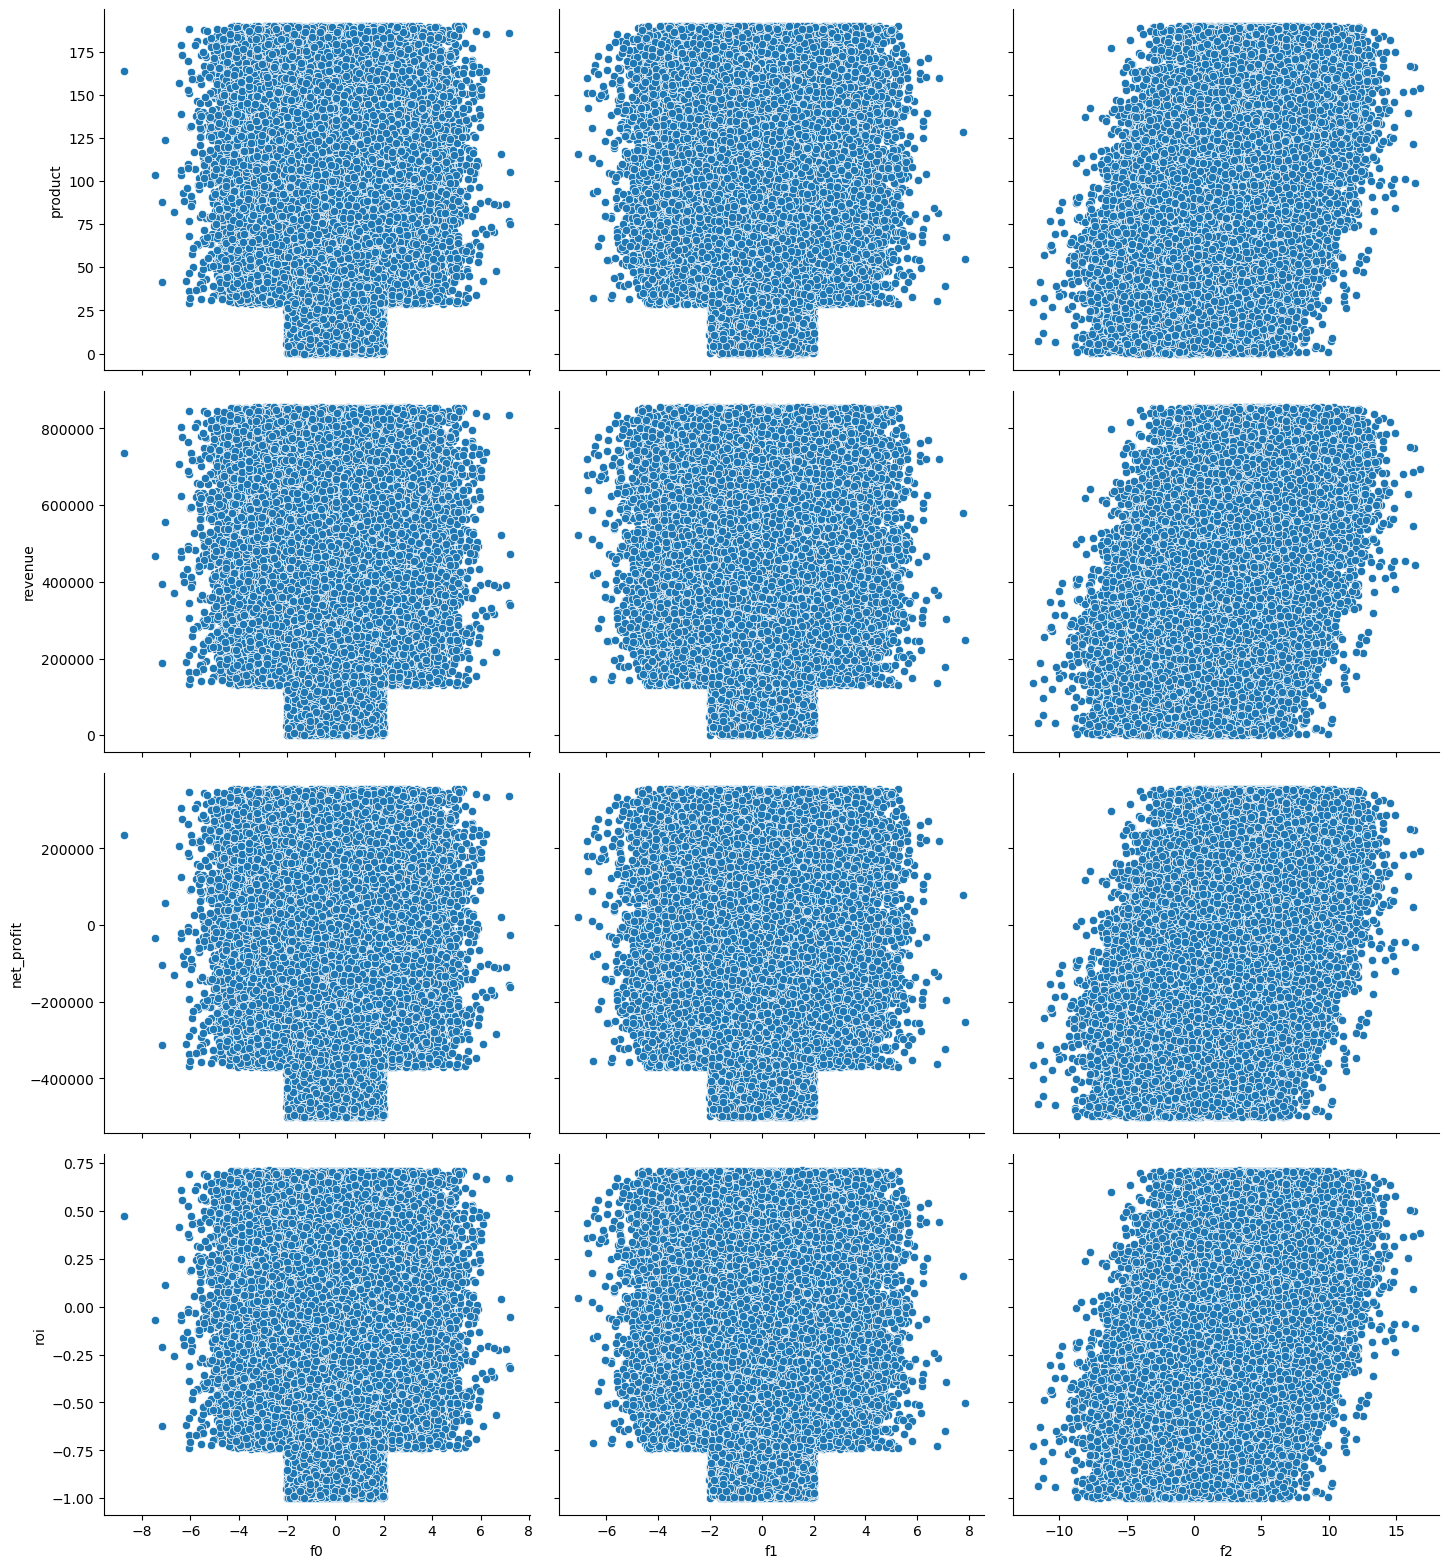

In [9]:
# Review relationships of fx columns against product, revenue, net_profit, and roi

r2_pair = sns.PairGrid(r2_df, x_vars=['f0', 'f1', 'f2'], 
                    y_vars=['product', 'revenue', 'net_profit', 'roi'],
                    height=4, aspect=1.2)
r2_pair.map(sns.scatterplot)

print(r2_df[['f2', 'product', 'revenue', 'net_profit', 'roi']].corr())
print()
print((r2_df['net_profit'] < 0).sum(), 'wells have negative net profit out of', len(r2_df))

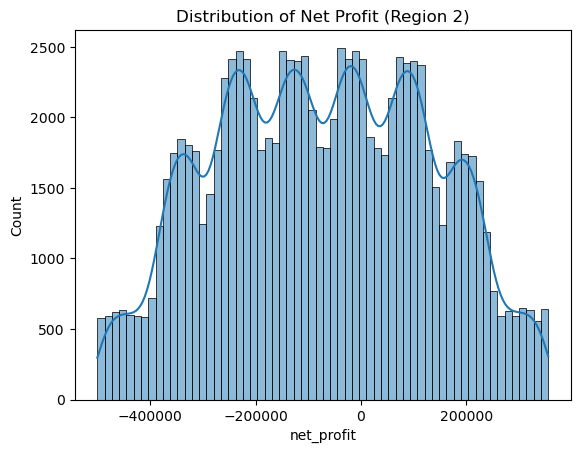

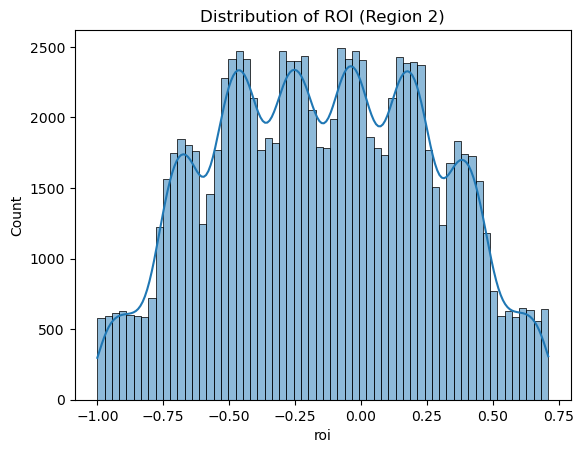

In [10]:
sns.histplot(r2_df['net_profit'], kde=True)
plt.title('Distribution of Net Profit (Region 2)')
plt.show()

sns.histplot(r2_df['roi'], kde=True)
plt.title('Distribution of ROI (Region 2)')
plt.show()

__CONCLUSIONS & COMMENTARY:__
- No missing data, duplicated rows, and all incumbent datatypes are correct.
- `revenue`, `op_ex`, `net_profit`, and `roi` columns created without issue.
- Among the feature columns `f0`, `f1`, and `f2`, only the `f2` column appeared to have any semblance of a linear relationship with the derived columns `product`, `revenue`, `net_profit`, and `roi`.
    - The `f0` and `f1` visualizations against those same columns simply appeared as masses of noisy clouds with no apparent relationship, and therefore shall excluded as features in training the forthcoming model.
    - The correlation for `f2` was calculated against all of the derived columns and a weak positive correlation was detected (~0.446), supporting this conclusion.
    - There was a large number of wells in Region 2 that have a negative net profit (61,822 / 100,000 = ~61.8%), which may be concerning in the later part of the analysis.
- The distributions of `net_profit` and `roi` were also visualized.
    - The visualizations showed that neither data slice is normally distributed, supporting the necessity of bootstrapping later on in the process.

### 4.4 Break-Even Volume Analysis

In [11]:
break_even_usd = 100_000_000 / 200  # $500,000 per well
price_per_thousand_barrels = 4500
break_even_volume = break_even_usd / price_per_thousand_barrels  # in thousand barrels

print(f"Break-even reserves per well: {break_even_volume:.2f} thousand barrels")

# Compare to average reserve volume in each region
avg_vol_r0 = r0_df['product'].mean()
avg_vol_r1 = r1_df['product'].mean()
avg_vol_r2 = r2_df['product'].mean()

print(f"Region 0 - Average reserves: {avg_vol_r0:.2f}")
print(f"Region 1 - Average reserves: {avg_vol_r1:.2f}")
print(f"Region 2 - Average reserves: {avg_vol_r2:.2f}")

Break-even reserves per well: 111.11 thousand barrels
Region 0 - Average reserves: 92.50
Region 1 - Average reserves: 68.83
Region 2 - Average reserves: 95.00


**CONCLUSIONS & COMMENTARY:**
- The break-even volume of oil reserves per well is **111.11 thousand barrels**.
- None of the regions' average oil reserves per well meet this threshold, therefore we must rely on **bootstrapped predictive modeling** to identify high-performing wells.
- Final regional selection will therefore depend on **both the predicted average profit** and each region's associated **`risk_of_loss_%`**, with the latter being a critical business constraint.

## 5. Region 0 Model Evaluation

### 5.1 Region 0 Cross-Validation

Avg RMSE across 5 folds: 37.53
Avg Predicted Volume: 92.45


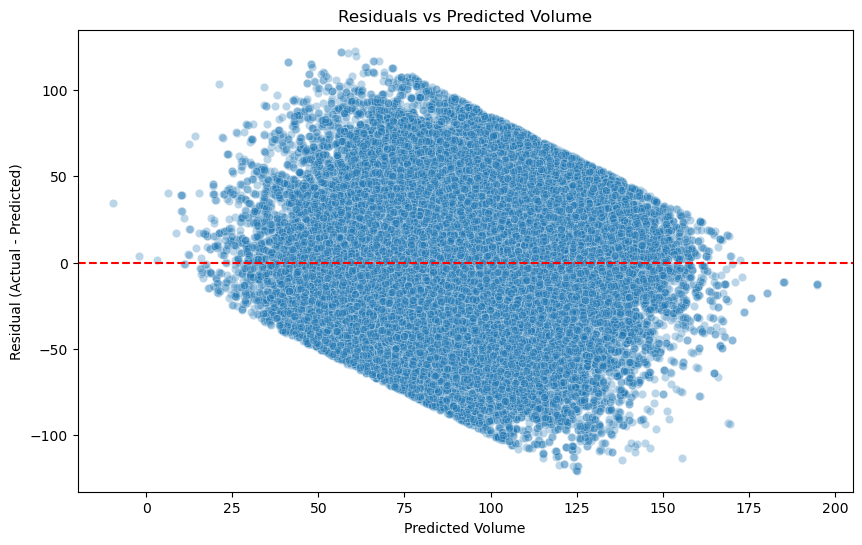

In [12]:
# Split off test set for final testing (80% training vs. 20% test)
# The training set shall be cross-validated with the custom function declared in Section 3 with a forced 75/25 training/val relation
r0_train, r0_test = train_test_split(r0_df, test_size=0.20, random_state=state)

# Separate feature and target from the training set
r0_feat_train = r0_train[['f0', 'f1', 'f2']] # Corrected to train on all of the `f` features
r0_target_train = r0_train['product'] # Corrected to target `product`

# Call repeated_random_cv_full to cross-validate 5 times with 75/25 split on training set
avg_rmse, avg_predicted_volume, preds_df = repeated_random_cv_full(r0_feat_train, r0_target_train)

# Calculate residuals
preds_df['residual'] = preds_df['actual_volume'] - preds_df['predicted_volume']

# Scatter plot of residuals vs. predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_volume', y='residual', data=preds_df, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Volume')
plt.xlabel('Predicted Volume')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()


__CONCLUSIONS & COMMENTARY:__
- Despite `f2` being the only column that exhibited any sort of relationship with the target column `product`, `f0` and `f1` shall also be included in model training and predictions in the event there are non-linear relationships or potentially obscure influences on each other that would aid in cumulative predictive improvement.
- The training set (80% of the total data, where 20% was held aside for the test set used in bootstrapping), was cross-validated in five iterations, where 75% of the initial seed training set was subdivided into another training set, and the remaining 25% was designated as the validation set.
- The custom cross-validation allowed for varietal sampling when the validation set changed over between iterations, allowing for a more robust assessment of the model.
    - This function averages over multiple folds with consistent training/validation proportions to avoid overfitting to a single fold.
- The **Average RMSE** across the 5 iterations was 37.53.
- The **Average Predicted Volume** across the 5 iterations was 92.45K barrels of oil.
- When the residuals were visualized against the predicted net profit, there appeared to be a very significant level of dispersion, which is indicative of underfitting, and that the model is struggling to generalize.

### 5.2 Region 0 Bootstrapping

{'average_profit': np.float64(4822775.629483443),
 '95%_ci_lower': np.float64(-593362.8237919062),
 '95%_ci_upper': np.float64(9874937.198704988),
 'risk_of_loss_%': np.float64(3.6999999999999997)}

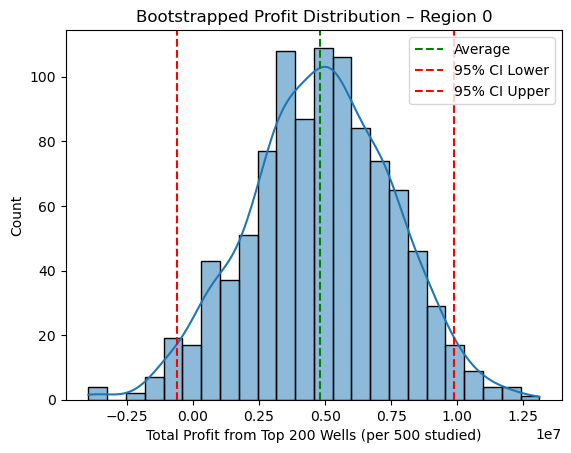

In [13]:
# Separate feature and target from the test set
r0_feat_test = r0_test[['f0', 'f1', 'f2']] # Corrected to include all 'f' columns as features
r0_target_test = r0_test['product'] # Changed target from `net_profit` to `product` to align with the training

profit_dist, summary = bootstrap_profit_analysis(r0_feat_test, r0_target_test, r0_feat_train, r0_target_train, rng=state)

display(summary)
sns.histplot(profit_dist, kde=True)
plt.axvline(summary['average_profit'], color='green', linestyle='--', label='Average')
plt.axvline(summary['95%_ci_lower'], color='red', linestyle='--', label='95% CI Lower')
plt.axvline(summary['95%_ci_upper'], color='red', linestyle='--', label='95% CI Upper')
plt.title('Bootstrapped Profit Distribution – Region 0')
plt.xlabel('Total Profit from Top 200 Wells (per 500 studied)')
plt.legend()
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The Region 0 test set features `f0`, `f1`, and `f2` and target `net_profit` were defined to begin this code block.
- The data was then bootstrapped using the custom boostrapping function defined in the **Initialization** section of this report, taking the test and training sets into account. 
- The profit distribution with control limits and mean were then visualized in a histogram.
- The results were close to promising for **Region 0**:
    - The Average Profit was positive at approximately $4.82M, however
    - The Risk of Loss % was 3.7%, which is above the OilyGiant risk threshold of 2.5%.
As the risk of loss is too great, **Region 0** may not be considered for oil well development depending on the output of the other regions.

## 6. Region 1 Model Evaluation

### 6.1 Region 1 Cross-Validation

Avg RMSE across 5 folds: 0.90
Avg Predicted Volume: 68.90


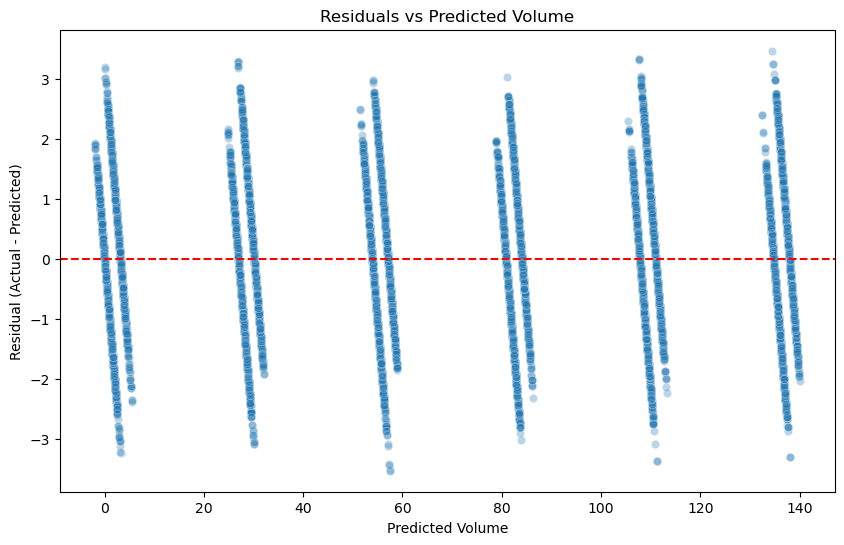

In [14]:
# Split off test set for final testing (80% training vs. 20% test)
# The training set shall be cross-validated with the custom function declared in Section 3 with a forced 75/25 training/val relation
r1_train, r1_test = train_test_split(r1_df, test_size=0.20, random_state=state)

# Separate feature and target from the training set
r1_feat_train = r1_train[['f0', 'f1', 'f2']] # Corrected to include other 'f' columns
r1_target_train = r1_train['product']

# Call repeated_random_cv_full to cross-validate 5 times with 75/25 split on training set
avg_rmse, avg_predicted_volume, preds_df = repeated_random_cv_full(r1_feat_train, r1_target_train)

# Calculate residuals
preds_df['residual'] = preds_df['actual_volume'] - preds_df['predicted_volume'] # Corrected to reflect volume instead of net_profit

# Scatter plot of residuals vs. predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_volume', y='residual', data=preds_df, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Volume')
plt.xlabel('Predicted Volume')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()


__CONCLUSIONS & COMMENTARY:__
- Despite `f2` being the only column that exhibited any sort of relationship with the target column `product`, `f0` and `f1` shall also be included in model training and predictions in the event there are non-linear relationships or potentially obscure influences on each other that would aid in cumulative predictive improvement.
- The training set (80% of the total data, where 20% was held aside for the test set used in bootstrapping), was cross-validated in five iterations, where 75% of the initial seed training set was subdivided into another training set, and the remaining 25% was designated as the validation set.
- The custom cross-validation allowed for varietal sampling when the validation set changed over between iterations, allowing for a more robust assessment of the model.
    - This function averages over multiple folds with consistent training/validation proportions to avoid overfitting to a single fold.
- The **Average RMSE** across the 5 iterations was much lower than **Region 0**, coming in at 0.90.
- The **Average Predicted Net Profit** across the 5 iterations was significantly lower than **Region 0**, coming in at a loss of 68.9K barrels.
    - The dispersion was also much less severe in comparison to **Region 0**.

### 6.2 Region 1 Bootstrapping

{'average_profit': np.float64(4314493.013646057),
 '95%_ci_lower': np.float64(460272.2665461589),
 '95%_ci_upper': np.float64(8402848.860681403),
 'risk_of_loss_%': np.float64(1.4000000000000001)}

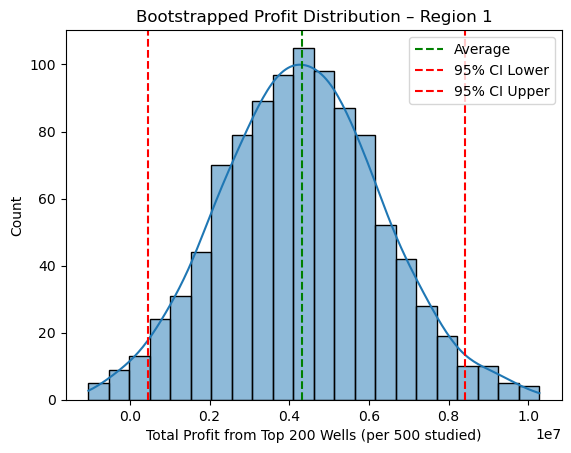

In [15]:
# Separate feature and target from the test set
r1_feat_test = r1_test[['f0', 'f1', 'f2']] # Corrected to include all `f` columns
r1_target_test = r1_test['product'] # Changed target from `net_profit` to `product`

profit_dist, summary = bootstrap_profit_analysis(r1_feat_test, r1_target_test, r1_feat_train, r1_target_train, rng=state)

display(summary)
sns.histplot(profit_dist, kde=True)
plt.axvline(summary['average_profit'], color='green', linestyle='--', label='Average')
plt.axvline(summary['95%_ci_lower'], color='red', linestyle='--', label='95% CI Lower')
plt.axvline(summary['95%_ci_upper'], color='red', linestyle='--', label='95% CI Upper')
plt.title('Bootstrapped Profit Distribution – Region 1')
plt.xlabel('Total Profit from Top 200 Wells (per 500 studied)')
plt.legend()
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The Region 1 test set features `f0`, `f1`, and `f2` and target `net_profit` were defined to begin this code block.
- The data was then bootstrapped using the custom boostrapping function defined in the **Initialization** section of this report, taking the test and training sets into account. 
- The profit distribution with control limits and mean were then visualized in a histogram.
- The results were promising for **Region 1**:
    - The Average Profit was positive at approximately $4.31M, and
    - The Risk of Loss % was only 1.4%, which is well below the OilyGiant risk threshold of 2.5%.
As the average profit is positive and the risk of loss is within OilyGiant's acceptable threshold, **Region 1** shall be considered for oil well development.

## 7. Region 2 Model Evaluation

### 7.1 Region 2 Cross-Validation

Avg RMSE across 5 folds: 40.09
Avg Predicted Volume: 94.89


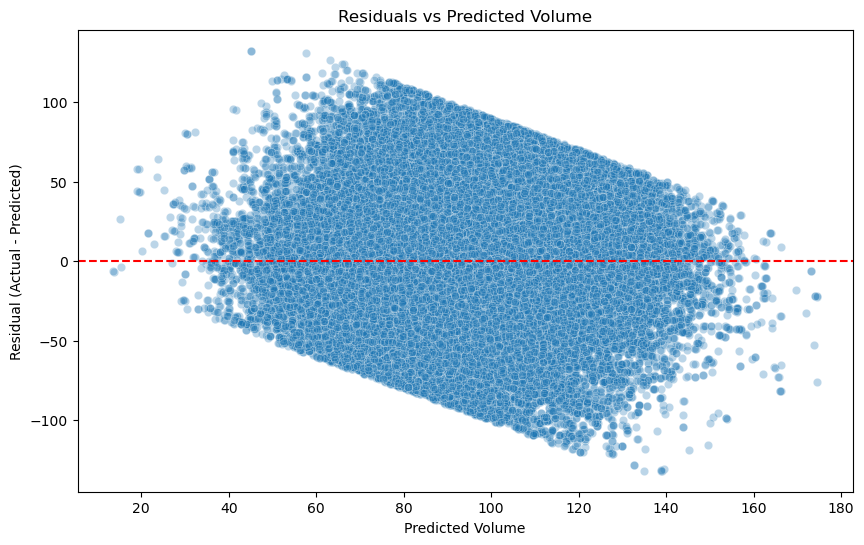

In [16]:
# Split off test set for final testing (80% training vs. 20% test)
# The training set shall be cross-validated with the custom function declared in Section 3 with a forced 75/25 training/val relation
r2_train, r2_test = train_test_split(r2_df, test_size=0.20, random_state=state)

# Separate feature and target from the training set
r2_feat_train = r2_train[['f0', 'f1', 'f2']] # Corrected to include all 'f' columns
r2_target_train = r2_train['product'] # Changed from net_profit to product

# Call repeated_random_cv_full to cross-validate 5 times with 75/25 split on training set
avg_rmse, avg_predicted_volume, preds_df = repeated_random_cv_full(r2_feat_train, r2_target_train) # Correct return to avg_predicted_volume

# Calculate residuals
preds_df['residual'] = preds_df['actual_volume'] - preds_df['predicted_volume'] # Changed referenced from net profit to volume

# Scatter plot of residuals vs. predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_volume', y='residual', data=preds_df, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Volume')
plt.xlabel('Predicted Volume')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()


__CONCLUSIONS & COMMENTARY:__
- Despite `f2` being the only column that exhibited any sort of relationship with the target column `product`, `f0` and `f1` shall also be included in model training and predictions in the event there are non-linear relationships or potentially obscure influences on each other that would aid in cumulative predictive improvement.
- The training set (80% of the total data, where 20% was held aside for the test set used in bootstrapping), was cross-validated in five iterations, where 75% of the initial seed training set was subdivided into another training set, and the remaining 25% was designated as the validation set.
- The custom cross-validation allowed for varietal sampling when the validation set changed over between iterations, allowing for a more robust assessment of the model.
    - This function averages over multiple folds with consistent training/validation proportions to avoid overfitting to a single fold.
- The **Average RMSE** across the 5 iterations was 40.09.
- The **Average Predicted Volume** across the 5 iterations was 94.89K barrels of oil.
- When the residuals were visualized against the predicted net profit, there appeared to be a very significant level of dispersion, which is indicative of underfitting, and that the model is struggling to generalize.

### 7.2 Region 2 Bootstrapping

{'average_profit': np.float64(3615678.933949883),
 '95%_ci_lower': np.float64(-1815621.3352770973),
 '95%_ci_upper': np.float64(8841577.227700563),
 'risk_of_loss_%': np.float64(9.4)}

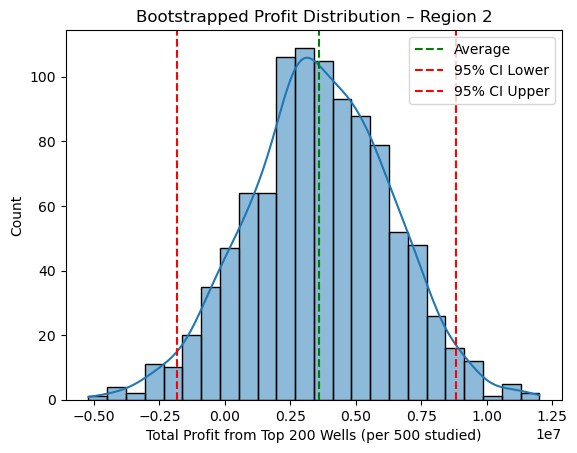

In [17]:
# Separate feature and target from the test set
r2_feat_test = r2_test[['f0', 'f1', 'f2']] # Corrected to include all `f` columns
r2_target_test = r2_test['product'] # Changed target from `net_profit` to `product`

profit_dist, summary = bootstrap_profit_analysis(r2_feat_test, r2_target_test, r2_feat_train, r2_target_train, rng=state)

display(summary)
sns.histplot(profit_dist, kde=True)
plt.axvline(summary['average_profit'], color='green', linestyle='--', label='Average')
plt.axvline(summary['95%_ci_lower'], color='red', linestyle='--', label='95% CI Lower')
plt.axvline(summary['95%_ci_upper'], color='red', linestyle='--', label='95% CI Upper')
plt.title('Bootstrapped Profit Distribution – Region 2')
plt.xlabel('Total Profit from Top 200 Wells (per 500 studied)')
plt.legend()
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The Region 2 test set feature `f2` and target `net_profit` were defined to begin this code block.
- The data was then bootstrapped using the custom boostrapping function defined in the **Initialization** section of this report, taking the test and training sets into account. 
- The profit distribution with control limits and mean were then visualized in a histogram.
- The results were not promising for **Region 2**:
    - The Average Profit was positive at approximately $3.62M, however
    - The Risk of Loss % was 9.4%, which is well above the OilyGiant risk threshold of 2.5%.
As the risk of loss is far too great, **Region 2** shall not be considered for oil well development.

## 8. Conclusion

__Project Objectives:__
- The objective of this project is to develop a model that will predict the optimal region for oil well development by maximizing the profit margin, within the bounds of acceptable risk of loss.
- There are three datasets representing various regions with undefined features influencing the viability of developments of these wells, as well as information on the volume of oil reserves present in each prospective well.

__Break-Even Analysis Commentary - Oil Reserve Volume per Well:__
- The break-even volume of oil reserves per well is approximately **111.11 thousand barrels**.
- The average reserve volumes in all three regions fall below this threshold:
  - Region 0: 92.50
  - Region 1: 68.83
  - Region 2: 95.00
- As no region meets the break-even level on average, we must rely on **bootstrapped predictive modeling** to identify high-performing wells.
- Final regional selection will therefore depend on **both the predicted average profit** and each region's associated **`risk_of_loss_%`**, with the latter being a critical business constraint.

<h3 style="color:#2E86C1;">📊 Bootstrapped Profit Simulation Summary</h3>

<table>
  <thead>
    <tr>
      <th>Region</th>
      <th>Average Profit</th>
      <th>95% Confidence Interval</th>
      <th>Risk of Loss (%)</th>
      <th>Meets Criteria?</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Region 0</strong></td>
      <td>\$4,822,775</td>
      <td>[-593,362, 9,874,937]</td>
      <td style="color:red;">3.7%</td>
      <td style="color:red;">❌ No</td>
    </tr>
    <tr>
      <td><strong>Region 1</strong></td>
      <td>\$4,314,493</td>
      <td>[460,272, 8,402,848]</td>
      <td style="color:green;">1.4%</td>
      <td style="color:green;">✅ Yes</td>
    </tr>
    <tr>
      <td><strong>Region 2</strong></td>
      <td>\$3,615,678</td>
      <td>[-1,815,621, 8,841,577]</td>
      <td style="color:red;">9.4%</td>
      <td style="color:red;">❌ No</td>
    </tr>
  </tbody>
</table>
      
__Next Steps & Recommendations:__
- OilyGiant should pursue oil well development in **Region 1** based on the analysis in the Profit Simulation Summary above.
- Although **Region 0** and **Region 2** appeared to have higher predicted profits in the cross-validation stage, both of these regions fell short during the bootstrapping phase when challenged by the test set holdout over 1000 iterations.
- Only **Region 1** meets OilyGiant's criteria for both positive Average Profit and acceptable Risk of Loss %.